M1 - Data Preparation and Preprocessing

Curso: Practical English / Machine Learning M1
Ano letivo: 2025/2026
Autor: Francisco Nunes / Daniel Rodrigues — 2022147843 / 2022103368
Data: 11/11/2025

🎯 Objective

This notebook presents the data understanding, cleaning, and preprocessing stages required for the M1 assignment.
The goal is to prepare a binary classification dataset with:

8–30 features (numeric, categorical, and ordinal),

≥ 1,000 rows,

clear and reproducible preprocessing pipelines.

🗂 Notebook Outline

Data Import and Overview

Exploratory Data Analysis (EDA)

Data Cleaning and Handling Missing Values

Feature Encoding (categorical & ordinal)

Feature Scaling and Outlier Treatment

Pipeline Construction with scikit-learn

Train/Test Split and Data Export

Conclusions and Next Steps

In [1]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

PROC_PATH = Path("../data/processed")
RAW_PATH = Path("../data/raw")
DATASET = PROC_PATH / "cardio_clean.parquet"

assert DATASET.exists(), "Falta o processed. Corre primeiro: python main.py preprocess"

df = pd.read_parquet(DATASET)
print(f"✅ Loaded: {df.shape[0]:,} rows × {df.shape[1]} cols")
df.head()


✅ Loaded: 70,000 rows × 14 cols


,id,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,bmi,cardio
0,0,2,168,62.0,110,80,1,1,0,0,1,50.4,21.97,0
1,1,1,156,85.0,140,90,3,1,0,0,1,55.4,34.93,1
2,2,1,165,64.0,130,70,3,1,0,0,0,51.6,23.51,1
3,3,2,169,82.0,150,100,1,1,0,0,1,48.2,28.71,1
4,4,1,156,56.0,100,60,1,1,0,0,0,47.8,23.01,0


In [2]:
print("\n--- Info ---")
df.info()

print("\n--- Missing values ---")
df.isna().sum().sort_values(ascending=False)



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  age_years    70000 non-null  float64
 12  bmi          70000 non-null  float64
 13  cardio       70000 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 7.5 MB

--- Missing values ---


id             0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
age_years      0
bmi            0
cardio         0
dtype: int64

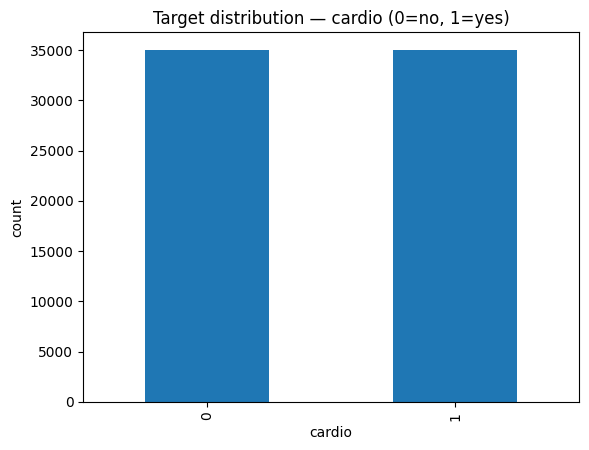

Proportion of positives: 0.5


In [3]:
# Target distribution
ax = df["cardio"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Target distribution — cardio (0=no, 1=yes)")
ax.set_xlabel("cardio"); ax.set_ylabel("count")
plt.show()

print("Proportion of positives:", df["cardio"].mean().round(3))


In [17]:
# Identify types after our main.py processing
target = "cardio"

num_cols = [c for c in df.select_dtypes(include="number").columns if c != target]

# Pega nas 'category' (e se por acaso alguma ficou como 'object', inclui também)
cat_cols = df.select_dtypes(include=["category"]).columns.tolist()
if not cat_cols:  # fallback, só para o caso de nada estar como 'category'
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)


Numeric: ['id', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'smoke', 'alco', 'active', 'age_years', 'bmi', 'pulse_pressure', 'map_mean']
Categorical: ['cholesterol', 'gluc', 'age_group', 'bmi_category']


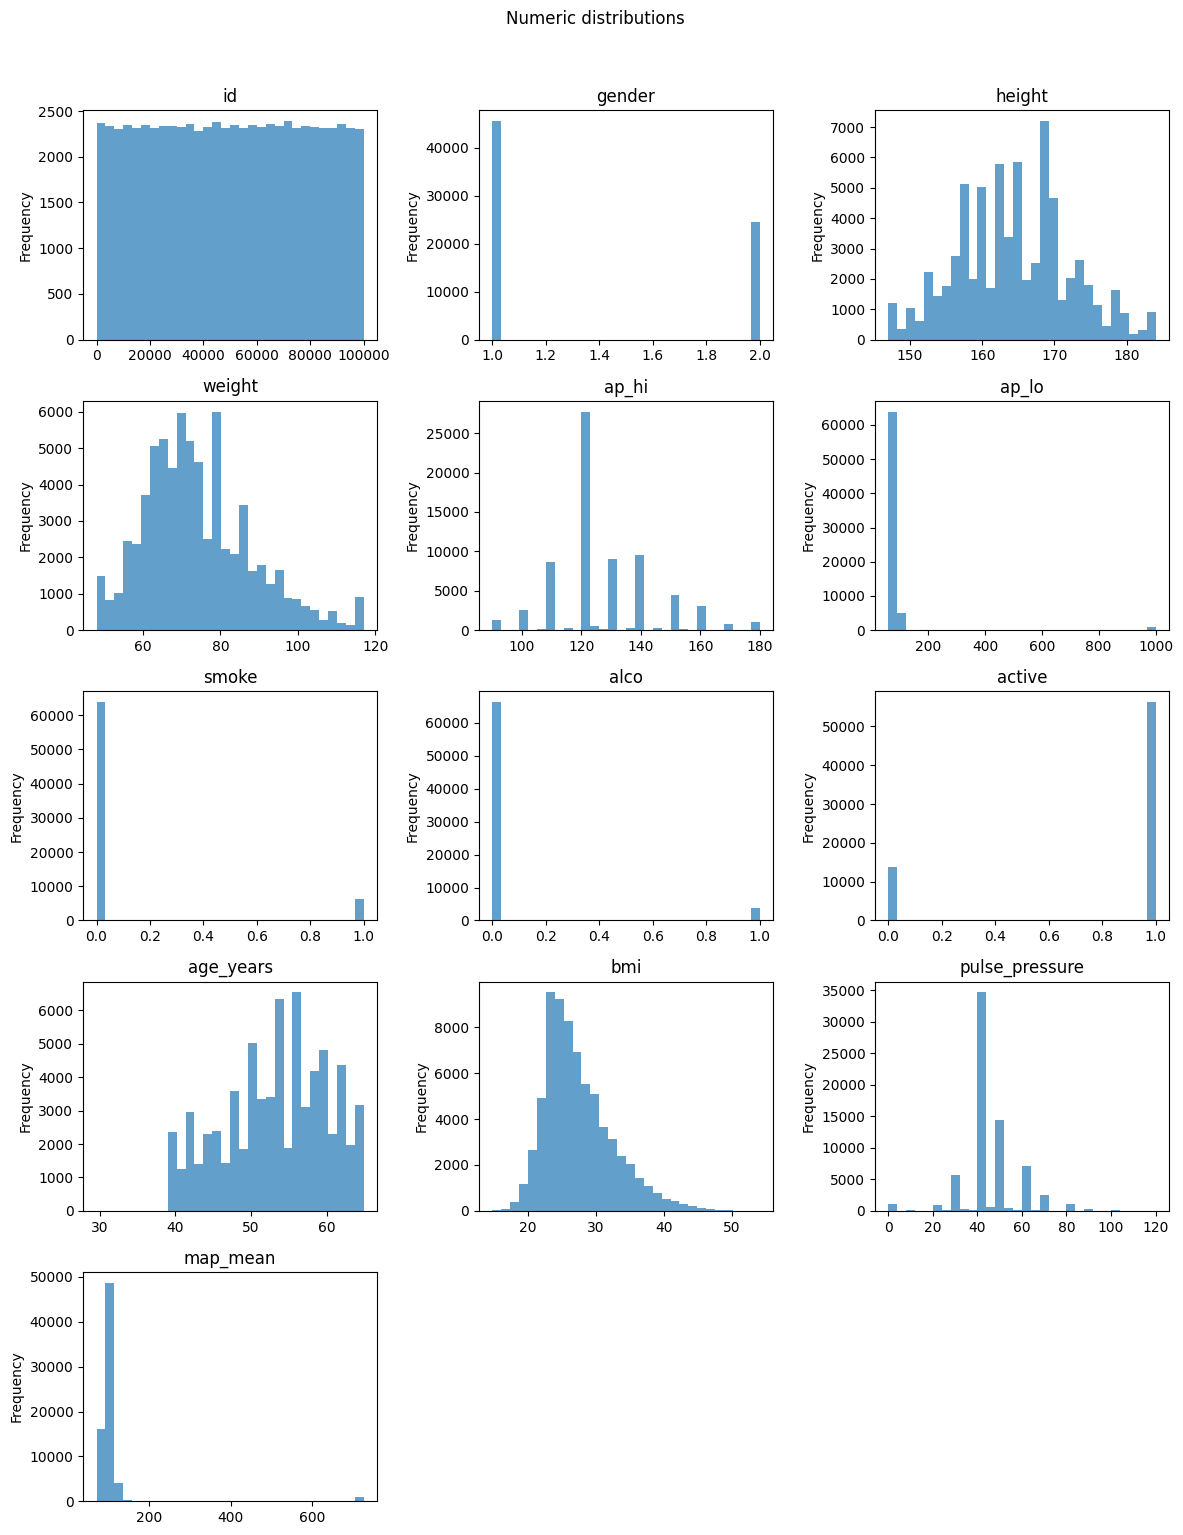

In [18]:
# Histograms for numeric features
n = len(num_cols); cols = 3; rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3)); axes = axes.ravel()

for i, c in enumerate(num_cols):
    df[c].plot(kind="hist", bins=30, alpha=0.7, ax=axes[i]); axes[i].set_title(c)
for j in range(i+1, len(axes)): fig.delaxes(axes[j])

plt.suptitle("Numeric distributions", y=1.02)
plt.tight_layout(); plt.show()


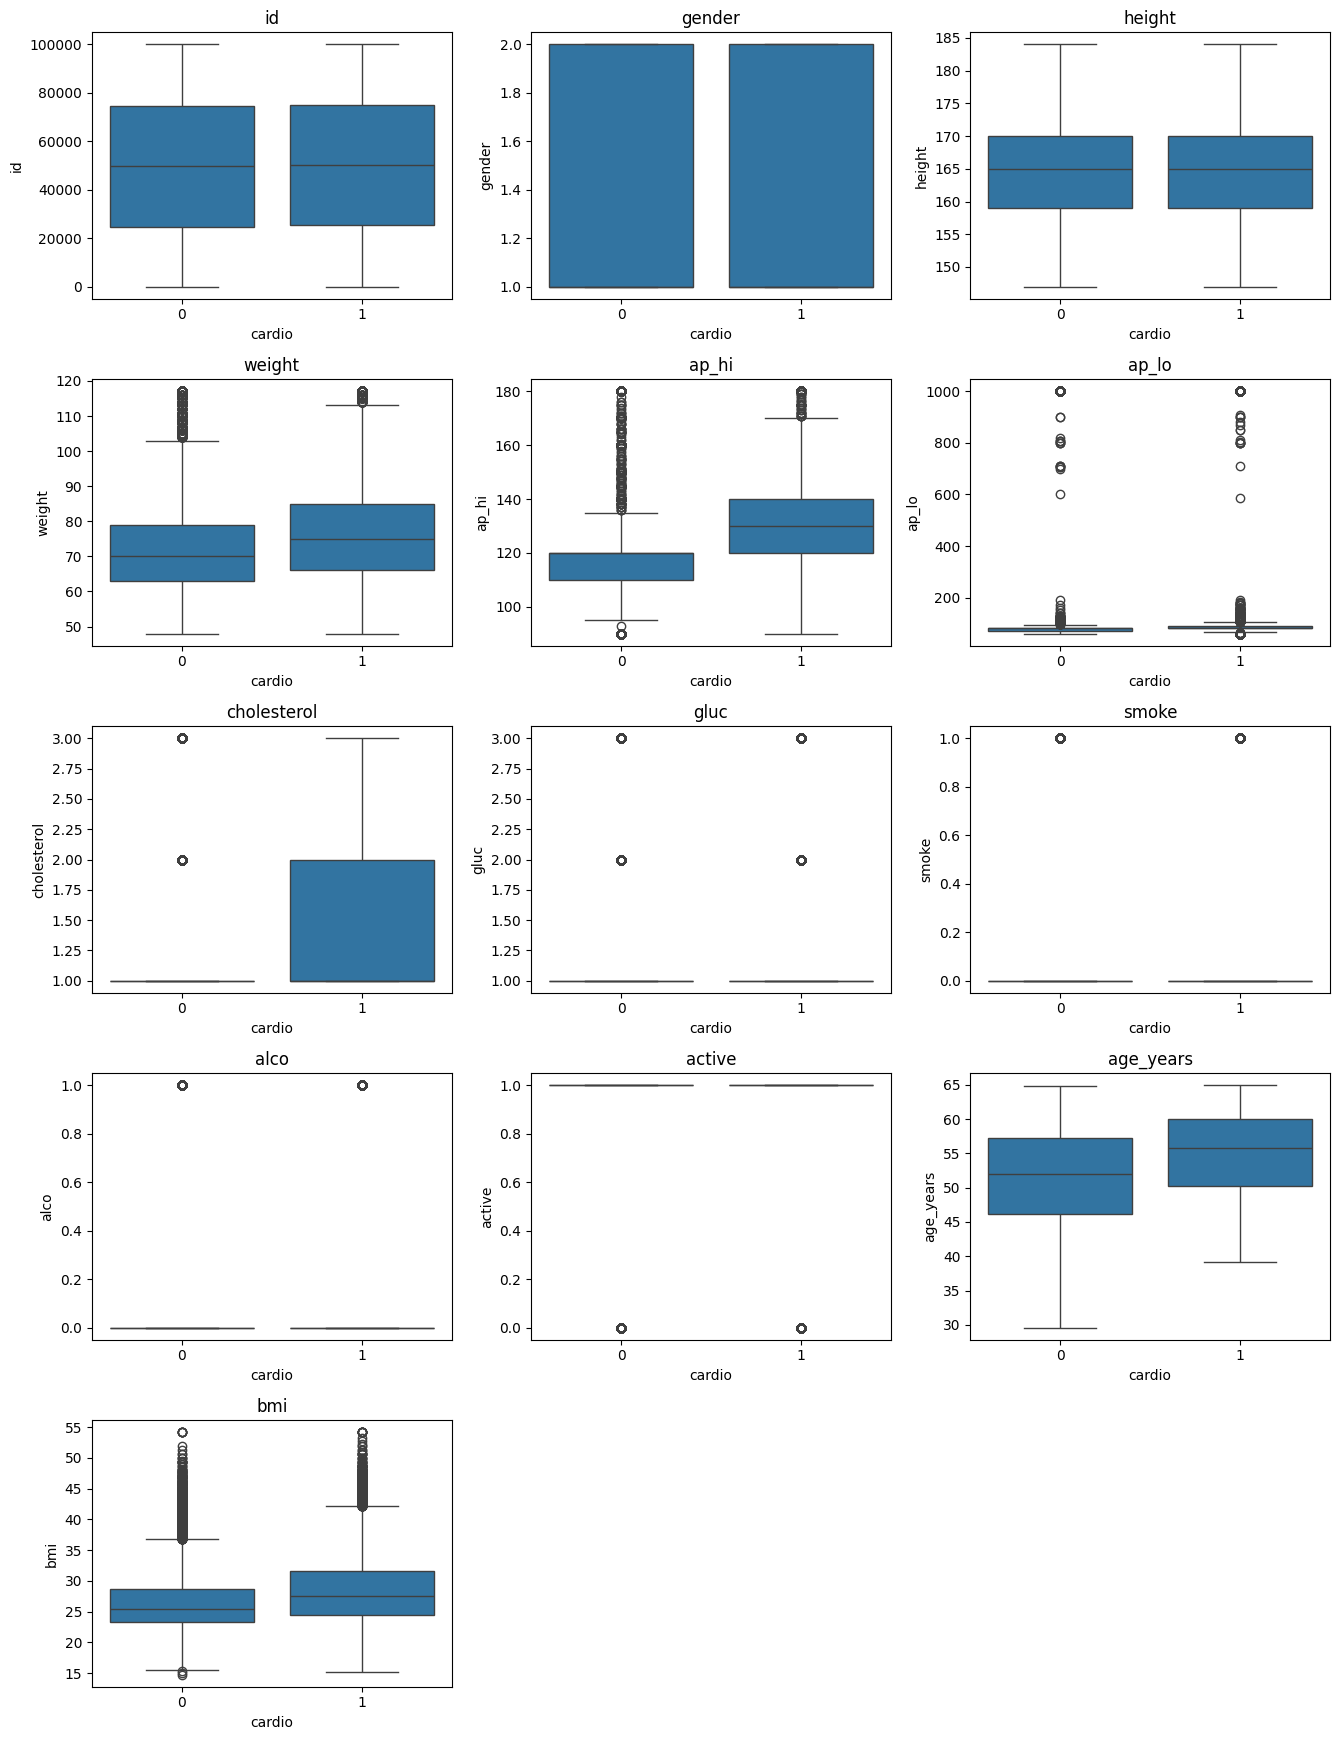

In [6]:
# Boxplots by target
cols = 3; rows = int(np.ceil(len(num_cols)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.5, rows*3.5)); axes = axes.ravel()

for i, c in enumerate(num_cols):
    sns.boxplot(data=df, x=target, y=c, ax=axes[i]); axes[i].set_title(c)
for j in range(i+1, len(axes)): fig.delaxes(axes[j])

plt.tight_layout(); plt.show()


cardio,0,1
cholesterol,,
1,0.559893,0.440107
2,0.397843,0.602157
3,0.234565,0.765435


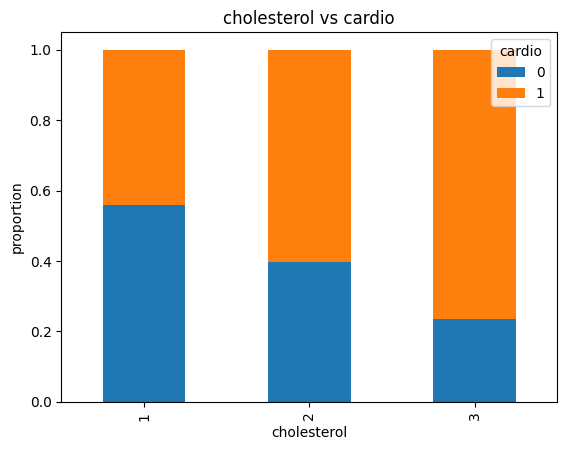

cardio,0,1
gluc,,
1,0.519410,0.480590
2,0.406936,0.593064
3,0.377978,0.622022


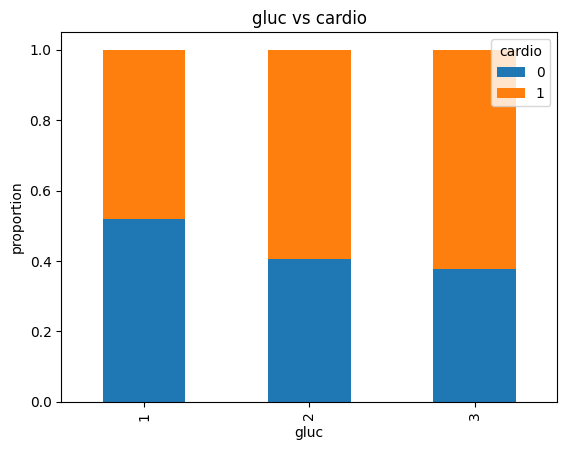

cardio,0,1
age_group,,
young,1.000000,0.000000
adult,0.702308,0.297692
senior,0.502040,0.497960
elderly,0.326434,0.673566


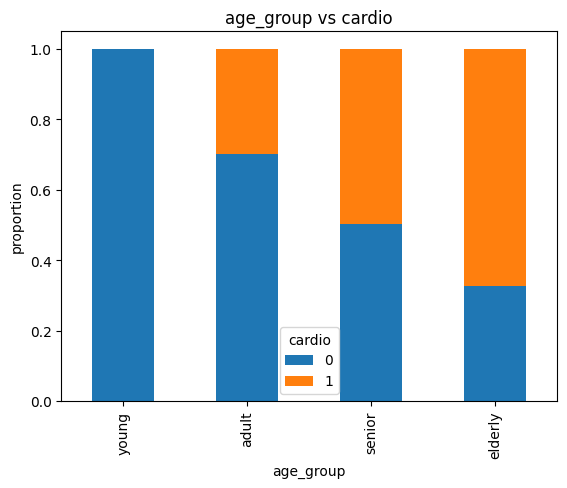

cardio,0,1
bmi_category,,
underweight,0.720698,0.279302
normal,0.599762,0.400238
overweight,0.490143,0.509857
obese,0.368907,0.631093


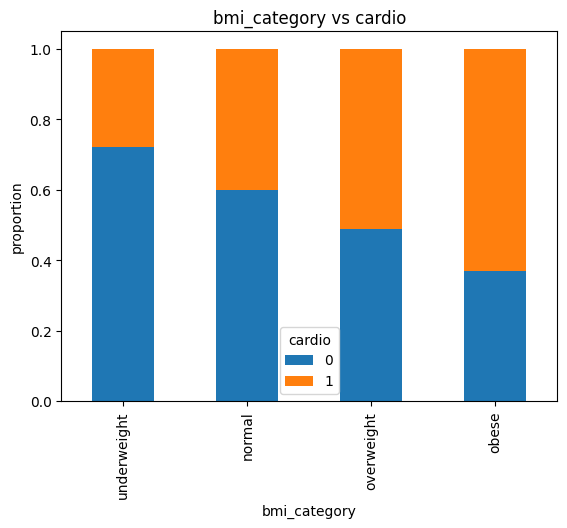

In [19]:
for c in cat_cols:
    ct = pd.crosstab(df[c], df[target], normalize="index")
    display(ct.style.set_caption(f"{c} vs {target}"))
    ax = ct.plot(kind="bar", stacked=True)
    ax.set_title(f"{c} vs {target}"); ax.set_ylabel("proportion")
    plt.show()

O main.py já fez: renomeação de colunas, age_years, clipping p1–p99 (ap_hi, ap_lo, height, weight) e cálculo do BMI.
Aqui apenas validamos nulos e removemos colunas irrelevantes/IDs (não existem IDs neste dataset).

In [8]:
# In this dataset, missingness should be minimal after preprocess; let's double-check:
df.isna().sum().sort_values(ascending=False)


id             0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
age_years      0
bmi            0
cardio         0
dtype: int64

Vamos enriquecer com features úteis e marcar adequadamente ordinais:

Pulse Pressure: pp = ap_hi - ap_lo

Mean Arterial Pressure (MAP): map = ap_lo + (ap_hi - ap_lo)/3

BMI categories (WHO)

Age groups

Ordinais: cholesterol, gluc (valores 1–3 com ordem)

In [9]:
# Add engineered numeric features
if {"ap_hi","ap_lo"}.issubset(df.columns):
    df["pulse_pressure"] = (df["ap_hi"] - df["ap_lo"]).clip(lower=0)
    df["map_mean"] = df["ap_lo"] + (df["ap_hi"] - df["ap_lo"]) / 3

# Age and BMI buckets
df["age_group"] = pd.cut(df["age_years"],
                         bins=[0, 30, 45, 60, 120],
                         labels=["young", "adult", "senior", "elderly"])

df["bmi_category"] = pd.cut(df["bmi"],
                            bins=[0, 18.5, 25, 30, 100],
                            labels=["underweight", "normal", "overweight", "obese"])

# Ensure categorical dtypes
for c in ["age_group", "bmi_category"]:
    df[c] = df[c].astype("category")

# cholesterol & gluc are ordinal (1,2,3)
if "cholesterol" in df.columns:
    df["cholesterol"] = df["cholesterol"].astype("category")
if "gluc" in df.columns:
    df["gluc"] = df["gluc"].astype("category")

df.head()


,id,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,bmi,cardio,pulse_pressure,map_mean,age_group,bmi_category
0,0,2,168,62.0,110,80,1,1,0,0,1,50.4,21.97,0,30,90.000000,senior,normal
1,1,1,156,85.0,140,90,3,1,0,0,1,55.4,34.93,1,50,106.666667,senior,obese
2,2,1,165,64.0,130,70,3,1,0,0,0,51.6,23.51,1,60,90.000000,senior,normal
3,3,2,169,82.0,150,100,1,1,0,0,1,48.2,28.71,1,50,116.666667,senior,overweight
4,4,1,156,56.0,100,60,1,1,0,0,0,47.8,23.01,0,40,73.333333,senior,normal


In [10]:
target = "cardio"

# Numeric base
num_features = [c for c in [
    "age_years","ap_hi","ap_lo","height","weight","bmi","pulse_pressure","map_mean"
] if c in df.columns]

# Binary already 0/1 in dataset
binary_features = [c for c in ["smoke","alco","active","gender"] if c in df.columns]

# Ordinal (with explicit order)
ordinal_features = [c for c in ["cholesterol","gluc","age_group","bmi_category"] if c in df.columns]
ordinal_orders = []
if "cholesterol" in ordinal_features: ordinal_orders.append([1,2,3])
if "gluc" in ordinal_features:        ordinal_orders.append([1,2,3])
if "age_group" in ordinal_features:   ordinal_orders.append(["young","adult","senior","elderly"])
if "bmi_category" in ordinal_features:ordinal_orders.append(["underweight","normal","overweight","obese"])

# Nominal (true categories without order) — any remaining category columns
nominal_candidates = df.select_dtypes("category").columns.tolist()
nominal_features = [c for c in nominal_candidates if c not in ordinal_features]

print("num_features:", num_features)
print("binary_features:", binary_features)
print("ordinal_features:", ordinal_features)
print("nominal_features:", nominal_features)


num_features: ['age_years', 'ap_hi', 'ap_lo', 'height', 'weight', 'bmi', 'pulse_pressure', 'map_mean']
binary_features: ['smoke', 'alco', 'active', 'gender']
ordinal_features: ['cholesterol', 'gluc', 'age_group', 'bmi_category']
nominal_features: []


In [11]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

bin_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

ord_pipe = Pipeline([
    ("ordinal", OrdinalEncoder(categories=ordinal_orders,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("bin", bin_pipe, binary_features),
    ("cat", cat_pipe, nominal_features),
    ("ord", ord_pipe, ordinal_features),
], remainder="drop")
preprocessor


,transformers,"[('num', ...), ('bin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [12]:
X = df.drop(columns=[target])
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

X_train_proc.shape, X_test_proc.shape


((56000, 16), (14000, 16))

In [13]:
import joblib, numpy as np

PROC_PATH.mkdir(parents=True, exist_ok=True)

joblib.dump(preprocessor, PROC_PATH / "preprocessor.joblib")
np.save(PROC_PATH / "X_train.npy", X_train_proc)
np.save(PROC_PATH / "X_test.npy",  X_test_proc)
y_train.to_csv(PROC_PATH / "y_train.csv", index=False)
y_test.to_csv(PROC_PATH / "y_test.csv",  index=False)

print("✅ Saved to data/processed/: preprocessor.joblib, X_train.npy, X_test.npy, y_train.csv, y_test.csv")


✅ Saved to data/processed/: preprocessor.joblib, X_train.npy, X_test.npy, y_train.csv, y_test.csv


In [14]:
# Quick verification
Xtr = np.load(PROC_PATH / "X_train.npy")
Xte = np.load(PROC_PATH / "X_test.npy")
ytr = pd.read_csv(PROC_PATH / "y_train.csv")
yte = pd.read_csv(PROC_PATH / "y_test.csv")

print("X_train:", Xtr.shape, " X_test:", Xte.shape)
print("y_train:", ytr.shape, " y_test:", yte.shape)
print("\nTrain pos rate:", ytr[target].mean().round(3), "Test pos rate:", yte[target].mean().round(3))


X_train: (56000, 16)  X_test: (14000, 16)
y_train: (56000, 1)  y_test: (14000, 1)

Train pos rate: 0.5 Test pos rate: 0.5
